In [0]:
from __future__ import print_function, division
from builtins import range, input


import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
# some configuration
MAX_SEQUENCE_LENGTH = 300
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 128

# load in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt', encoding="utf8", errors='ignore'):
  line = line.rstrip()
  if not line:
    continue
  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

all_lines = input_texts + target_texts

In [3]:
all_lines

['<sos> Two roads diverged in a yellow wood,',
 '<sos> And sorry I could not travel both',
 '<sos> And be one traveler, long I stood',
 '<sos> And looked down one as far as I could',
 '<sos> To where it bent in the undergrowth;',
 '<sos> Then took the other, as just as fair,',
 '<sos> And having perhaps the better claim',
 '<sos> Because it was grassy and wanted wear,',
 '<sos> Though as for that the passing there',
 '<sos> Had worn them really about the same,',
 '<sos> And both that morning equally lay',
 '<sos> In leaves no step had trodden black.',
 '<sos> Oh, I kept the first for another day!',
 '<sos> Yet knowing how way leads on to way',
 '<sos> I doubted if I should ever come back.',
 '<sos> I shall be telling this with a sigh',
 '<sos> Somewhere ages and ages hence:',
 '<sos> Two roads diverged in a wood, and I,',
 '<sos> I took the one less traveled by,',
 '<sos> And that has made all the difference.',
 '<sos> Whose woods these are I think I know.',
 '<sos> His house is in the

In [0]:
# convert the sentences (strings) into integers
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [5]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [6]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [7]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-04-27 18:51:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-27 18:51:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-27 18:51:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall("glove")
zip_ref.close()

In [8]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [9]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [0]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1


In [0]:
from tensorflow import keras
from tensorflow.keras import layers


In [0]:
filepath = 'Models'

In [0]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

mc = tf.keras.callbacks.ModelCheckpoint(
    filepath= filepath, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch'
)




In [0]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [15]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = tf.keras.Input(shape=(max_sequence_length,))
initial_h = tf.keras.Input(shape=(LATENT_DIM,))
initial_c = tf.keras.Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = tf.keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = tf.keras.layers.Dense(num_words, activation='softmax')
output = dense(x)

model = tf.keras.Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
,
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)
print(model.summary())

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 300)      917100      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________

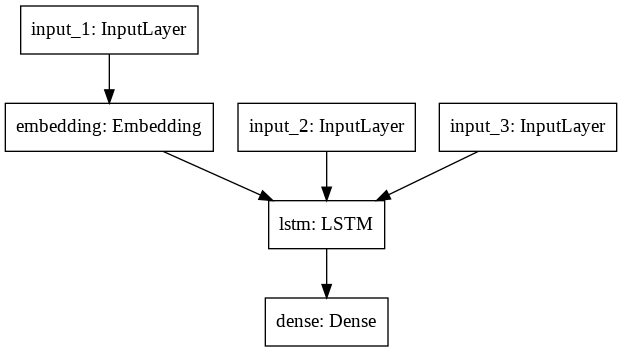

In [16]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)


Training model...
Epoch 1/200
36/36 [==============================] - 1s 36ms/step - loss: 5.0951 - accuracy: 0.0796 - val_loss: 5.0228 - val_accuracy: 0.0833
Epoch 2/200
36/36 [==============================] - 1s 24ms/step - loss: 4.4677 - accuracy: 0.0833 - val_loss: 5.0162 - val_accuracy: 0.0833
Epoch 3/200
36/36 [==============================] - 1s 24ms/step - loss: 4.3053 - accuracy: 0.0887 - val_loss: 4.9894 - val_accuracy: 0.0880
Epoch 4/200
36/36 [==============================] - 1s 24ms/step - loss: 4.1719 - accuracy: 0.0989 - val_loss: 4.9207 - val_accuracy: 0.0903
Epoch 5/200
36/36 [==============================] - 1s 24ms/step - loss: 4.0533 - accuracy: 0.1039 - val_loss: 4.8797 - val_accuracy: 0.0935
Epoch 6/200
36/36 [==============================] - 1s 24ms/step - loss: 3.9593 - accuracy: 0.1082 - val_loss: 4.8718 - val_accuracy: 0.0949
Epoch 7/200
36/36 [==============================] - 1s 24ms/step - loss: 3.8802 - accuracy: 0.1117 - val_loss: 4.8599 - val_accur

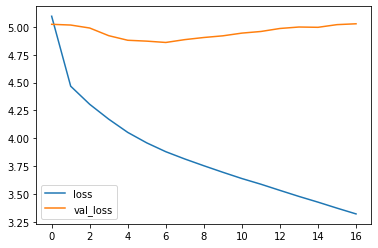

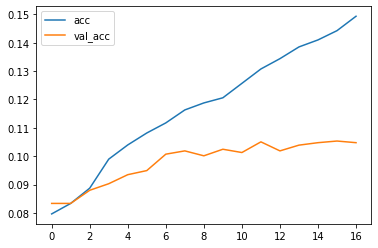

In [17]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT, callbacks = [es,mc]
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [0]:
# make a sampling model
input2 = tf.keras.Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = tf.keras.Model([input2, initial_h, initial_c], [output2, h, c])


# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}


In [0]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf....")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)



In [0]:
def call():# generate a n lines poem
  while True:
    lines = int(input("Enter the no of lines you want to be generated:"))
    for _ in range(lines):
      print(sample_line())

    ans = input("---generate another? [Y/n]---")
    if ans and ans[0].lower().startswith('n'):
      break

In [21]:
call()

Enter the no of lines you want to be generated:2
and not the tying across in it.
"you my winter dragging by lived.
---generate another? [Y/n]---3
Enter the no of lines you want to be generated:4
standing was your posts
bottle again?' you incredulous in the find again.
was she have lightning to two eye is;
a mother, and wonder in his hitched hell-for-leather.'
---generate another? [Y/n]---
Enter the no of lines you want to be generated:5
with the wherewith like is sit settled
not you have died. still open mustn't.
old creaking no, with the drinking song
it knock! not once something for to hitched pretense
but just the smoking that in the attic like back tempt one
---generate another? [Y/n]---6
Enter the no of lines you want to be generated:7
it heard of his strengths, of the unless
other off to this fill she matter to?
souls, to which through from his 'going
does bless a-known that you're ears
i why i had playhouse on across her mine.
i finished let it you guess books.
guess if mother n